In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd

In [3]:
# manually add a2e-mmc repos to PYTHONPATH if needed
import os, sys
module_path = os.path.join(os.environ['HOME'],'tools','a2e-mmc')
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_spectrum, plot_timeheight
import assessment.studies.budget_components_coupling.helpers as helper

In [5]:
import matplotlib as mpl
import matplotlib.dates as mdates
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16

# SWIFT budget components coupling study: Plot single microscale case
written by [Dries Allaerts](mailto:dries.allaerts@nrel.gov)

Produce figures for the paper, "Coupling mesoscale momentum and temperature budget components to a microscale LES solver for wind energy applications", under submission to Boundary-Layer Meteorology. This notebook depends on:
- SOWFA simulation `run.tency.w0_L0`
- reference data:
    - WRF data (version 3.7.1), extracted from the actual SOWFA input files
    - TTU tower data, generated in `process_TTU_tower.ipynb`
    - TTU radar data, generated in `process_TTU_radar.ipynb`

Main directories on Eagle

In [6]:
datadir = '/projects/mmc/dallaert/budget_component_coupling/'
referencedir = '/projects/mmc/dallaert/referenceData/'

Name of SOWFA simulation folder

In [7]:
micro_data = 'run.tency.w0_L0'

Reference data

In [8]:
# Datasets generated in process_TTU_tower.ipynb, which can be found in
# a2e-mmc/assessment/datasets/SWiFT/
tower_data_10min = 'TTU_tilt_corrected_20131108-09_10min.csv'
tower_data       = 'TTU_tilt_corrected_20131108-09.csv'

# Dataset generated in process_TTU_radar.ipynb, which can be found in
# a2e-mmc/assessment/datasets/SWiFT/
radar_data = 'TTU_obs_QC_20131108.csv'

# WRF data is extracted from the SOWFA input files
wrf_data = 'drivingData_Rerun/w0_L0'

Heights and times at which spectra are computed

In [9]:
zhub = [80., ]
selected_times = ['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 06:00:00']

Output folder to store figures

In [10]:
figuredir = 'Figures'

## 1. Load microscale data

In [11]:
%%time
data = helper.load_sowfa_data(
    os.path.join(datadir,micro_data),
    times=selected_times,heights=zhub,
    interval='1h',window_size='10min',
)
micro_prob_10min = data[0]
micro_prob_60min = data[1]
micro_prob_fspec = data[2]
micro_pavg_10min = data[3]
micro_pavg_60min = data[4]

# CPU times: user 2min 30s, sys: 16.4 s, total: 2min 46s
# Wall time: 7min 10s

CPU times: user 2min 48s, sys: 18.9 s, total: 3min 7s
Wall time: 3min 8s


## 2. Load reference data

In [12]:
%%time
tower_10min, tower_60min = helper.load_tower_reference_data(os.path.join(referencedir,tower_data_10min))

# CPU times: user 48.2 ms, sys: 3.9 ms, total: 52.1 ms
# Wall time: 98.4 ms

CPU times: user 48.6 ms, sys: 4.08 ms, total: 52.6 ms
Wall time: 98.2 ms


In [13]:
tower_10min.columns

Index(['RH', 'T', 'Ts', 'p', 'theta', 'thetas', 'u', 'v', 'w', 'wspd', 'wdir',
       'uu', 'vv', 'ww', 'uv', 'vw', 'uw', 'Tw', 'thetaw', 'u*', 'TKE', 'TI',
       'Tv', 'thetav'],
      dtype='object')

In [14]:
%%time
tower_fspec = helper.load_tower_reference_spectra(os.path.join(referencedir,tower_data),
                                                    selected_times,zhub,
                                                    interval='1h',window_size='10min')

# CPU times: user 6.9 s, sys: 122 ms, total: 7.02 s
# Wall time: 7.18 s

CPU times: user 6.81 s, sys: 169 ms, total: 6.98 s
Wall time: 7.02 s


In [15]:
%%time
radar_scan0, radar_scan1 = helper.load_radar_reference_data(os.path.join(referencedir,radar_data))
radar_scan0_1h = radar_scan0.unstack().resample('1h').mean().stack()
radar_scan1_1h = radar_scan1.unstack().resample('1h').mean().stack()

# CPU times: user 18.9 ms, sys: 5.75 ms, total: 24.6 ms
# Wall time: 61.1 ms

CPU times: user 45.4 ms, sys: 186 µs, total: 45.5 ms
Wall time: 104 ms


In [16]:
%%time
data = helper.load_wrf_reference_data(os.path.join(datadir,wrf_data))
wrf_pavg_10min = data[0]
wrf_pavg_60min = data[1]

# CPU times: user 12.4 s, sys: 36.9 ms, total: 12.5 s
# Wall time: 12.6 s

CPU times: user 7.83 s, sys: 21.9 ms, total: 7.85 s
Wall time: 7.94 s


## 3. Plot results

Time-height contour plot

/home/dallaert/.conda-envs/py3env/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


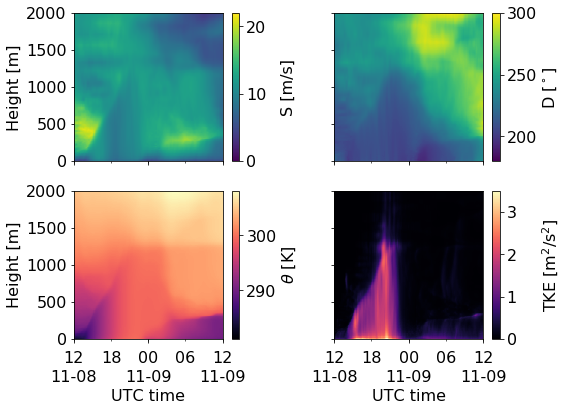

In [17]:
fig,ax,cbar = plot_timeheight(
    datasets=micro_pavg_10min,
    fields = ['wspd','wdir','thetav','TKE'],
    fieldlimits={'wspd': (0,22), 'wdir': (180,300), 'theta': (280,310), 'TKE': (0,3.5)},
    fieldlabels={'wspd': 'S [m/s]', 'wdir': r'D [$^\circ$]','thetav':r'$\theta$ [K]'},
    timelimits=('2013-11-08 12:00:00','2013-11-09 12:00:00'),
    # Set custom colorschemes
    colorschemes={'wspd': 'viridis', 'wdir': 'viridis', 'thetav': 'magma', 'TKE': 'magma'},
    # Order plots in a grid of 2 by 2
    ncols=2,
    # Set subfigure size
    subfigsize=(4,3),
    # Set raterized to True to reduce size of eps and pdf figures
    rasterized=True
)
 
fig.subplots_adjust(wspace=0.4)

# Adjust xaxis tick locations
ax[0,0].xaxis.set_minor_locator(mpl.dates.HourLocator(byhour=range(24),interval=6))
ax[0,0].xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
ax[0,0].xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('\n%m-%d'))

#Move xs tick down slightly to avoid overlap with y ticks
for axi in np.asarray(ax[-1,:]).ravel():
    axi.tick_params(axis='x', which='minor', pad=10)
    axi.tick_params(axis='x', which='major', pad=10)

#Save figure
figname = 'w0L0_timeheight'
plt.savefig(os.path.join(datadir,figuredir,figname+'.png'),bbox_inches='tight')
plt.savefig(os.path.join(datadir,figuredir,figname+'.eps'),bbox_inches='tight')
plt.savefig(os.path.join(datadir,figuredir,figname+'.pdf'),bbox_inches='tight')

Time history plot at hub height

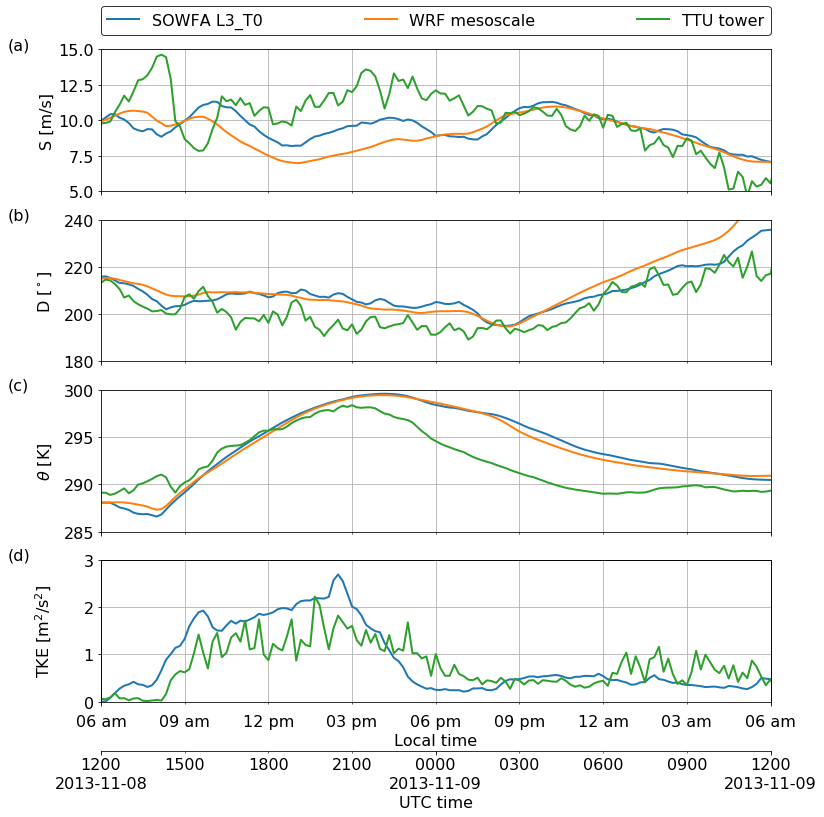

In [18]:
fig,ax,ax2 = plot_timehistory_at_height(
    datasets = {'SOWFA L3_T0': micro_pavg_10min,
                'WRF mesoscale': wrf_pavg_10min,
                'TTU tower': tower_10min,},
    fields = ['wspd','wdir','thetav','TKE'],
    heights = zhub,
    fieldlimits={'wspd':(5,15),'wdir':(180,240),'thetav':(285,300),'TKE':(0,3)},
    fieldlabels={'wspd': 'S [m/s]', 'wdir': r'D [$^\circ$]','thetav':r'$\theta$ [K]'},
    timelimits=('2013-11-08 12:00:00','2013-11-09 12:00:00'),
    # Add additional x axis showing local time
    plot_local_time=True, local_time_offset = -6,
    # Label subplots
    labelsubplots=True,
    # Additional keyword arguments to personalize plotting style
    linewidth=2,linestyle='-',marker=None,
)

#Move xs tick down slightly to avoid overlap with y ticks in ax[1]
ax[-1].tick_params(axis='x', which='minor', pad=10)
ax[-1].tick_params(axis='x', which='major', pad=10)

# Adjust xaxis tick locations
ax2.xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))

#Place legend at the top
leg = ax[0].legend(loc='lower left',bbox_to_anchor=(0.0,1.1,1.0,0.0),
             borderaxespad=0,fontsize=16,ncol=3,mode='expand')
leg.get_frame().set_edgecolor('k')

#Save figure
figname = 'w0L0_timehistory'
plt.savefig(os.path.join(datadir,figuredir,figname+'.png'),bbox_inches='tight')
plt.savefig(os.path.join(datadir,figuredir,figname+'.eps'),bbox_inches='tight')
plt.savefig(os.path.join(datadir,figuredir,figname+'.pdf'),bbox_inches='tight')

Vertical profiles for different times of the day

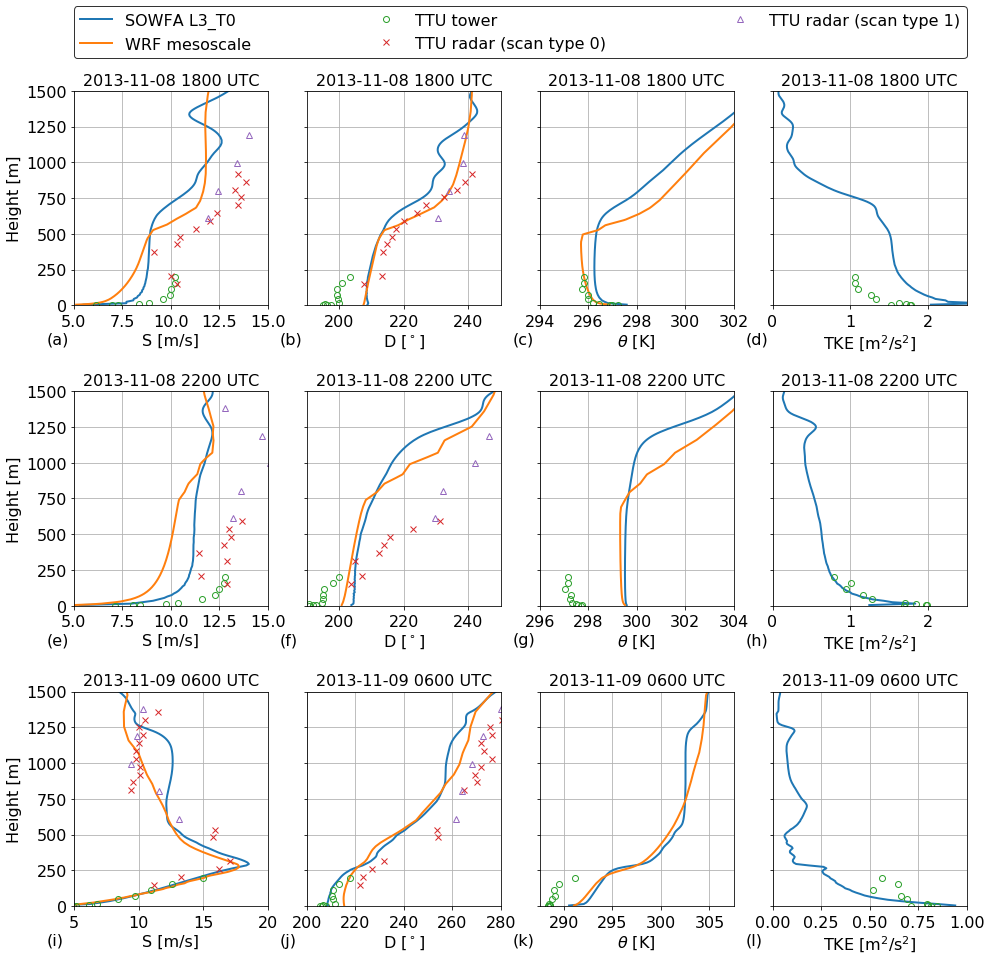

In [19]:
fig,ax = plot_profile(
    datasets={'SOWFA L3_T0':micro_pavg_60min,
              'WRF mesoscale':wrf_pavg_60min,
              'TTU tower':tower_60min,
              'TTU radar (scan type 0)':radar_scan0_1h,
              'TTU radar (scan type 1)':radar_scan1_1h},
    fields=['wspd','wdir','thetav','TKE'],
    times=selected_times,
    heightlimits=(0,1500),
    fieldlimits={'wspd':(5,15),'wdir':(190,250),'TKE':(0,2.5)},
    # Stack results by dataset instead of times
    stack_by_datasets=True,
    # Field labels
    fieldlabels={'wspd':'S [m/s]','wdir':r'D [$^\circ$]','thetav':r'$\theta$ [K]'},
    # Change field order to have different fields correspond to different columns instead of rows
    fieldorder='F',
    # Label subplots
    labelsubplots=True,
    # Dataset specific arguments relating to plotting style
    datasetkwargs={'TTU tower':{'linestyle':'','marker':'o','mfc':'none','markersize':6,'color':'#2ca02c'},
                   'TTU radar (scan type 0)':{'linestyle':'','marker':'x','mfc':'none','markersize':6,'color':'#d62728'},
                   'TTU radar (scan type 1)':{'linestyle':'','marker':'^','mfc':'none','markersize':6,'color':'#9467bd'}
                  },
    # Additional keyword arguments to personalize plotting style
    linewidth=2,
)

# Set velocity limits
ax[2,0].set_xlim([5,20])
# Set wind direction limits
ax[2,1].set_xlim([200,280])
# Set temperature limits
ax[0,2].set_xlim([294,302])
ax[1,2].set_xlim([296,304])
ax[2,2].set_xlim([287.5,307.5])
# Set TKE limits
ax[2,3].set_xlim([0,1])

#Move xs tick down slightly to avoid overlap with y ticks
for axi in np.asarray(ax).ravel():
    axi.tick_params(axis='x', pad=5)

#Place legend at the top
ax[0,-1].get_legend().remove()
ax[0,0].legend()
handles, labels = ax[0,0].get_legend_handles_labels()
ax[0,0].get_legend().remove()

leg = fig.legend(handles, labels, loc = 'lower left', bbox_to_anchor = (.125,.91,.775,0.0),
         borderaxespad=0,ncol=3,fontsize=16,
         bbox_transform = plt.gcf().transFigure,mode='expand')
leg.get_frame().set_edgecolor('k')

#Save figure
figname = 'w0L0_profiles'
plt.savefig(os.path.join(datadir,figuredir,figname+'.png'),bbox_inches='tight')
plt.savefig(os.path.join(datadir,figuredir,figname+'.eps'),bbox_inches='tight')
plt.savefig(os.path.join(datadir,figuredir,figname+'.pdf'),bbox_inches='tight')

Spectra plot

In [40]:
# Plot with time in columns

# fig,ax = plot_spectrum(
#     datasets={'SOWFA L3_T0':micro_prob_fspec,'TTU tower':tower_fspec},
#     height=zhub,
#     times=selected_times,
#     fields=['wspd','w','thetav'],
#     freqlimits=(0.001,0.3),
#     fieldlimits={'wspd':(1.0e-3,1.0e3),'w':(1.0e-3,1.0e2),'thetav':(1.0e-4,2.0e1)},
#     datasetkwargs={'TTU tower':{'color':'#2ca02c'}},
# )

# for axi in np.asarray(ax[1:,:]).ravel():
#     axi.set_title('')
    
# for i,axi in enumerate(np.asarray(ax).ravel()):
#     axi.text(.85,.9,'('+chr(i+97)+')',transform=axi.transAxes,size=16)
    
# #Place legend at the top
# handles, labels = ax[0,-1].get_legend_handles_labels()
# ax[0,-1].get_legend().remove()

# leg = fig.legend(handles, labels, loc = 'lower left', bbox_to_anchor = (.125,.91,.775,0.0),
#          borderaxespad=0,ncol=2,fontsize=16,
#          bbox_transform = plt.gcf().transFigure,mode='expand')
# leg.get_frame().set_edgecolor('k')

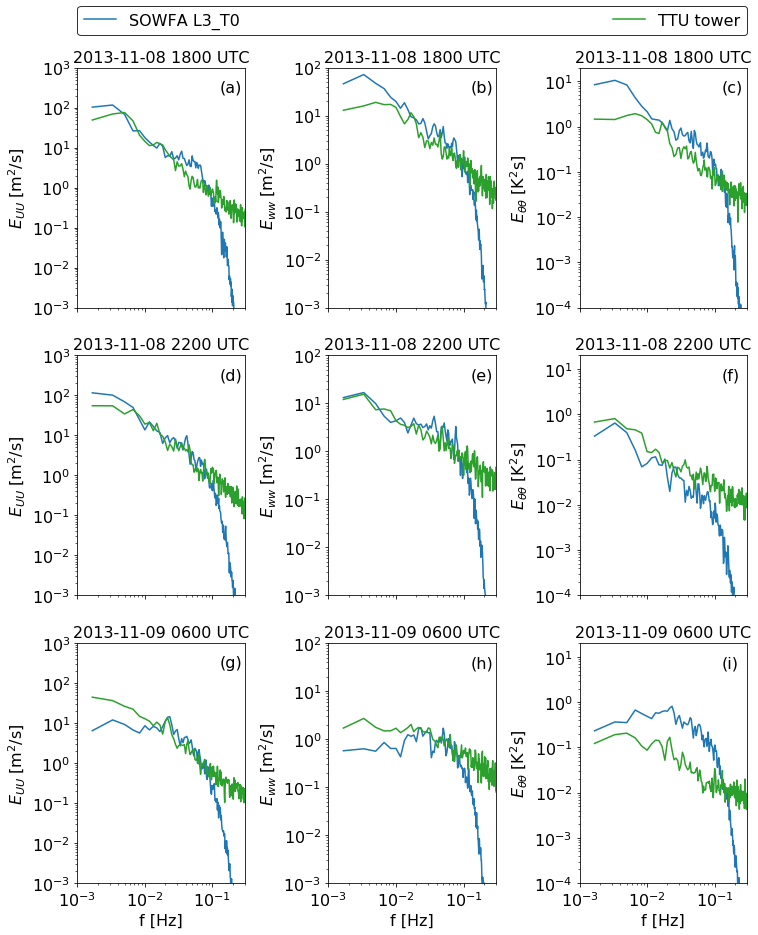

In [41]:
# Plot with time in rows
fig,ax = plt.subplots(3,3,sharex=True,figsize=(12,15))
fig.subplots_adjust(wspace=0.5)
fig,ax = plot_spectrum(
    datasets={'SOWFA L3_T0':micro_prob_fspec,'TTU tower':tower_fspec},
    height=zhub,
    times=selected_times,
    fields=['wspd','w','thetav'],
    freqlimits=(0.001,0.3),
    fieldlimits={'wspd':(1.0e-3,1.0e3),'w':(1.0e-3,1.0e2),'thetav':(1.0e-4,2.0e1)},
    datasetkwargs={'TTU tower':{'color':'#2ca02c'}},
    # Transpose axes to get time in rows
    fig=fig,ax=ax.T
)

# Transpose back
ax = ax.T

# Set x axis labels
ax[0,2].set_xlabel('')
ax[1,2].set_xlabel('')
ax[2,0].set_xlabel('f [Hz]')
ax[2,1].set_xlabel('f [Hz]')

# Set y axis labels
ax[1,0].set_ylabel(r'$E_{UU}\;[\mathrm{m^2/s}]$')
ax[1,1].set_ylabel(r'$E_{ww}\;[\mathrm{m^2/s}]$')
ax[1,2].set_ylabel(r'$E_{\theta\theta}\;[\mathrm{K^2s}]$')
ax[2,0].set_ylabel(r'$E_{UU}\;[\mathrm{m^2/s}]$')
ax[2,1].set_ylabel(r'$E_{ww}\;[\mathrm{m^2/s}]$')
ax[2,2].set_ylabel(r'$E_{\theta\theta}\;[\mathrm{K^2s}]$')

for i,axi in enumerate(np.asarray(ax).ravel()):
    axi.text(.85,.9,'('+chr(i+97)+')',transform=axi.transAxes,size=16)
    
#Place legend at the top
handles, labels = ax[-1,0].get_legend_handles_labels()
ax[-1,0].get_legend().remove()

leg = fig.legend(handles, labels, loc = 'lower left', bbox_to_anchor = (.125,.91,.775,0.0),
         borderaxespad=0,ncol=2,fontsize=16,
         bbox_transform = plt.gcf().transFigure,mode='expand')
leg.get_frame().set_edgecolor('k')

#Save figure
figname = 'w0L0_spectra'
plt.savefig(os.path.join(datadir,figuredir,figname+'.png'),bbox_inches='tight')
plt.savefig(os.path.join(datadir,figuredir,figname+'.eps'),bbox_inches='tight')
plt.savefig(os.path.join(datadir,figuredir,figname+'.pdf'),bbox_inches='tight')